# Определение неэффективности оператора

«Нупозвони» — провайдер виртуальной телефонии. Его клиенты — колл-центры, которые: 

- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

**Описание данных:**

Колонки в `telecom_dataset.csv.zip`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

## Загрузка данных и подготовка к исследованию

### Чтение файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

In [2]:
try:
    telecom_clients = pd.read_csv('/datasets/telecom_clients.csv')
    telecom_dataset = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    telecom_clients = pd.read_csv('telecom_clients.csv')
    telecom_dataset = pd.read_csv('telecom_dataset.csv')

In [3]:
telecom_clients.info()
telecom_clients.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
581,167651,B,2019-09-24
622,167002,B,2019-08-28
234,167827,C,2019-10-02
112,168115,C,2019-10-14
399,166773,C,2019-08-19
727,166554,B,2019-08-08
394,168093,C,2019-10-14
309,167059,C,2019-08-29
620,167004,B,2019-08-28
78,167584,C,2019-09-21


In [4]:
telecom_dataset.info()
telecom_dataset.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
15515,166899,2019-10-23 00:00:00+03:00,out,False,894656.0,False,28,1434,1603
17579,166940,2019-11-25 00:00:00+03:00,out,True,897030.0,True,1,0,0
43801,168018,2019-11-13 00:00:00+03:00,out,False,945900.0,False,53,559,1399
28557,167183,2019-10-30 00:00:00+03:00,out,False,932292.0,False,2,156,174
37439,167626,2019-10-13 00:00:00+03:00,in,False,919166.0,False,53,3396,3751
9105,166658,2019-10-16 00:00:00+03:00,in,False,890404.0,False,8,1370,1477
52763,168361,2019-11-18 00:00:00+03:00,out,False,945310.0,False,77,16617,18297
48663,168187,2019-11-13 00:00:00+03:00,in,False,937958.0,False,6,1089,1154
23586,167102,2019-10-18 00:00:00+03:00,in,False,NaN,True,1,0,2
46354,168091,2019-11-25 00:00:00+03:00,out,False,958468.0,False,9,1021,1124


### Предобработка данных

- telecom_clients

Информации о времени нет, поэтому оставляем только дату, приводим к соответствующему типу:

In [5]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')
telecom_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Проверка на явные дубликаты:

In [6]:
telecom_clients.duplicated().sum()

0

Проверка на наличие пропусков:

In [7]:
telecom_clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [8]:
telecom_clients['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [9]:
telecom_clients['date_start'].unique()

array(['2019-08-15T00:00:00.000000000', '2019-08-23T00:00:00.000000000',
       '2019-10-29T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-16T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-08-29T00:00:00.000000000', '2019-10-17T00:00:00.000000000',
       '2019-10-28T00:00:00.000000000', '2019-10-03T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-09-19T00:00:00.000000000', '2019-10-23T00:00:00.000000000',
       '2019-10-20T00:00:00.000000000', '2019-10-24T00:00:00.000000000',
       '2019-10-18T00:00:00.000000000', '2019-10-11T00:00:00.000000000',
       '2019-10-10T00:00:00.000000000', '2019-10-02T00:00:00.000000000',
       '2019-10-21T00:00:00.000000000', '2019-10-14T00:00:00.000000000',
       '2019-10-07T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-09-24T00:00:00.000000000', '2019-09-18T00:00:00.000000000',
       '2019-08-22T00:00:00.000000000', '2019-08-05

In [10]:
print(telecom_clients['date_start'].min())
print(telecom_clients['date_start'].max())

2019-08-01 00:00:00
2019-10-31 00:00:00


- telecom_dataset

С столбцом date аналогично прошлому датасету - оставим дату:

In [11]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'])
telecom_dataset['sessions_date'] = telecom_dataset['date'].dt.date.astype('datetime64')
telecom_dataset = telecom_dataset.drop('date', axis=1)
telecom_dataset.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date
0,166377,in,False,NaN,True,2,0,4,2019-08-04
1,166377,out,True,880022.0,True,3,0,5,2019-08-05
2,166377,out,True,880020.0,True,1,0,1,2019-08-05
3,166377,out,True,880020.0,False,1,10,18,2019-08-05
4,166377,out,False,880022.0,True,3,0,25,2019-08-05


In [12]:
telecom_dataset.loc[(telecom_dataset['operator_id'] == 880022.0)].sort_values(by='sessions_date').sample()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date
153,166377,out,False,880022.0,False,5,1243,1265,2019-09-06


Тип колонки internal приведем к типу bool:

In [13]:
telecom_dataset['internal'] = telecom_dataset['internal'].astype(bool)

Проверка на явные дубликаты:

In [14]:
telecom_dataset.duplicated().sum()

4900

Доля дубликатов:

In [15]:
round(telecom_dataset.duplicated().sum() * 100/len(telecom_dataset), 2)

9.09

Удалим:

In [16]:
telecom_dataset.drop_duplicates(inplace=True)
telecom_dataset.duplicated().sum()

0

Проверка на наличие пропусков:

In [17]:
telecom_dataset.isna().sum()

user_id                   0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
sessions_date             0
dtype: int64

Пропуски в долях:

In [18]:
round(telecom_dataset.isna().sum() * 100/len(telecom_dataset), 2)

user_id                 0.00
direction               0.00
internal                0.00
operator_id            15.22
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
sessions_date           0.00
dtype: float64

Столбец internal показывает звонок внешний или внутренний, пропусков меньше 1%, удалим: 

In [19]:
telecom_dataset = telecom_dataset.dropna(axis='index', how='any', subset=['internal'])
telecom_dataset.isna().sum()

user_id                   0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
sessions_date             0
dtype: int64

Пропусков в столбце operator_id достаточно много, рассмотрим подробнее:

In [20]:
display(telecom_dataset[telecom_dataset['operator_id'].isna()].sample(20))

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date
44091,168021,in,False,NaN,True,2,0,36,2019-11-19
29836,167264,in,False,NaN,True,3,0,73,2019-11-04
35760,167543,in,False,NaN,True,4,0,21,2019-10-20
13735,166800,in,False,NaN,True,1,0,20,2019-11-11
42547,167955,in,False,NaN,True,22,0,11,2019-11-26
42873,167977,in,False,NaN,True,8,0,237,2019-10-31
39006,167654,in,False,NaN,True,21,0,274,2019-11-25
38203,167650,in,False,NaN,True,8,0,126,2019-10-27
43373,167989,in,False,NaN,True,1,0,19,2019-11-22
42511,167955,in,False,NaN,True,5,0,0,2019-11-12


Добавим новый столбец waiting_time и для дальнейшего исследования:

In [21]:
telecom_dataset['waiting_time'] = round((telecom_dataset['total_call_duration'] - telecom_dataset['call_duration'])/telecom_dataset['calls_count'], 0).astype(int)
telecom_dataset.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time
0,166377,in,False,NaN,True,2,0,4,2019-08-04,2
1,166377,out,True,880022.0,True,3,0,5,2019-08-05,2
2,166377,out,True,880020.0,True,1,0,1,2019-08-05,1
3,166377,out,True,880020.0,False,1,10,18,2019-08-05,8
4,166377,out,False,880022.0,True,3,0,25,2019-08-05,8


In [22]:
operator_id_isna = telecom_dataset[telecom_dataset['operator_id'].isna()]

In [23]:
len(operator_id_isna)

7456

In [24]:
len(operator_id_isna[operator_id_isna['waiting_time'] == 0])

516

In [25]:
len(operator_id_isna[operator_id_isna['internal'] == False])

7078

In [26]:
len(operator_id_isna.loc[(operator_id_isna['internal'] == False) & (operator_id_isna['direction'] == 'in')])

6932

In [27]:
len(operator_id_isna.loc[(operator_id_isna['internal'] == False) & (operator_id_isna['direction'] == 'out')])

146

В основном это именно внешние входящие звонки, возможно, что это те звонки, которые не перевелись на какого-либо оператора. Оставим

In [28]:
telecom_dataset['sessions_date'].unique()

array(['2019-08-04T00:00:00.000000000', '2019-08-05T00:00:00.000000000',
       '2019-08-06T00:00:00.000000000', '2019-08-07T00:00:00.000000000',
       '2019-08-08T00:00:00.000000000', '2019-08-09T00:00:00.000000000',
       '2019-08-12T00:00:00.000000000', '2019-08-13T00:00:00.000000000',
       '2019-08-14T00:00:00.000000000', '2019-08-15T00:00:00.000000000',
       '2019-08-16T00:00:00.000000000', '2019-08-19T00:00:00.000000000',
       '2019-08-20T00:00:00.000000000', '2019-08-21T00:00:00.000000000',
       '2019-08-22T00:00:00.000000000', '2019-08-23T00:00:00.000000000',
       '2019-08-24T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-08-27T00:00:00.000000000', '2019-08-28T00:00:00.000000000',
       '2019-08-29T00:00:00.000000000', '2019-08-30T00:00:00.000000000',
       '2019-09-02T00:00:00.000000000', '2019-09-03T00:00:00.000000000',
       '2019-09-04T00:00:00.000000000', '2019-09-05T00:00:00.000000000',
       '2019-09-06T00:00:00.000000000', '2019-09-09

In [29]:
telecom_dataset['direction'].unique()

array(['in', 'out'], dtype=object)

In [30]:
telecom_dataset['internal'].unique()

array([False,  True])

In [31]:
telecom_dataset['is_missed_call'].unique()

array([ True, False])

In [32]:
print(telecom_dataset['calls_count'].min())
print(telecom_dataset['calls_count'].max())

1
4817


In [33]:
print(telecom_dataset['call_duration'].min())
print(telecom_dataset['call_duration'].max())

0
144395


In [34]:
print(telecom_dataset['total_call_duration'].min())
print(telecom_dataset['total_call_duration'].max())

0
166155


**Выводы:**
Рассмотрели оба датасета, выполнили проверку на дубликаты, пропуски, привели данные к нужному типу.

Данные готовы к исследованию.

## Исследовательский анализ данных

### Изучение количественных данных

In [35]:
def plot(column, bins, range_b):
    """
     Эта функция для построения гистограмм,
     в качестве аргумента - столбец (из telecom_dataset)
     
    """
    telecom_dataset[column].plot(kind='hist',
                        bins=bins, 
                        grid=True,
                        range=(0, range_b),
                        figsize=(10,5), 
                        color=['#FFCF56'],
                       );
    plt.xlabel(column)
    plt.ylabel('count');

In [36]:
def box_plot(column):
    
    """
     Эта функция для построения диаграммы размаха,
     в качестве аргумента - столбец (из telecom_dataset)
     
    """
    
    telecom_dataset[column].plot(kind='box',figsize=(7,5));

In [37]:
telecom_dataset[['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']].describe().T

,count,mean,std,min,25%,50%,75%,max
calls_count,49002.0,16.462777,63.604098,1.0,1.0,4.0,12.0,4817.0
call_duration,49002.0,866.282091,3775.503352,0.0,0.0,37.0,570.0,144395.0
total_call_duration,49002.0,1156.558202,4451.473661,0.0,46.0,208.0,901.0,166155.0
waiting_time,49002.0,16.826170,13.882893,0.0,8.0,14.0,22.0,465.0


#### Распределение длительности звонков

Посмотрим разброс значений по **call_duration**

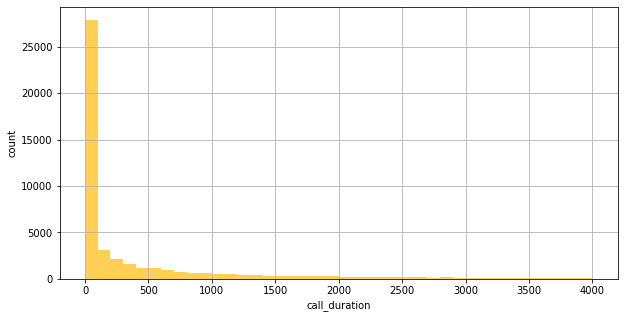

In [38]:
plot('call_duration', 40, 4000)

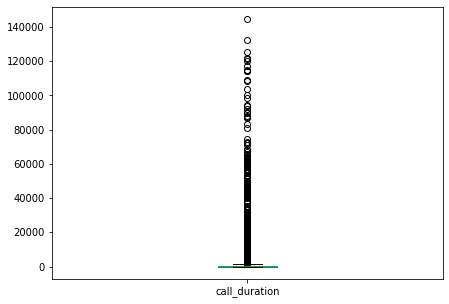

In [39]:
box_plot('call_duration')

In [40]:
np.percentile(telecom_dataset['call_duration'], [95, 99])

array([ 3725.95, 10314.91])

Посмотрим разброс значений по **total_call_duration** 

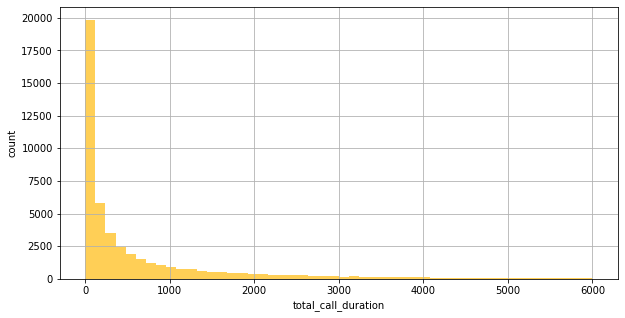

In [41]:
plot('total_call_duration', 50, 6000)

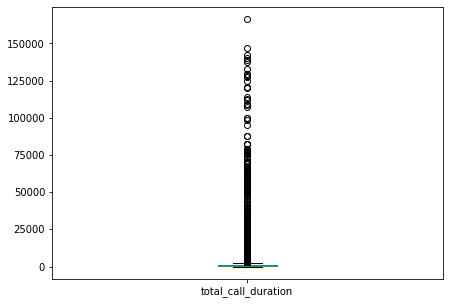

In [42]:
box_plot('total_call_duration')

In [43]:
np.percentile(telecom_dataset['total_call_duration'], [95, 99])

array([ 4531., 12956.])

#### Распределение количества звонков 

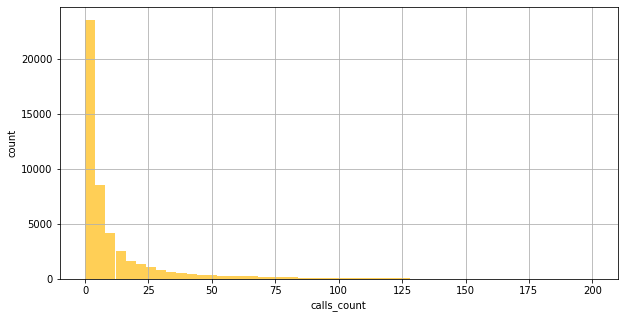

In [44]:
plot('calls_count', 50, 200)

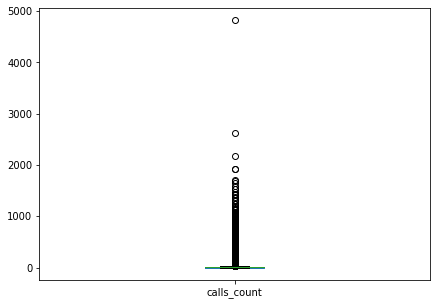

In [45]:
box_plot('calls_count')

In [46]:
np.percentile(telecom_dataset['calls_count'], [95, 99])

array([ 62., 165.])

#### Распределение времени ожидания

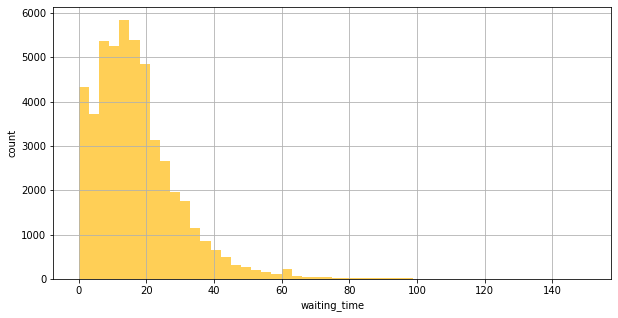

In [47]:
plot('waiting_time', 50, 150)

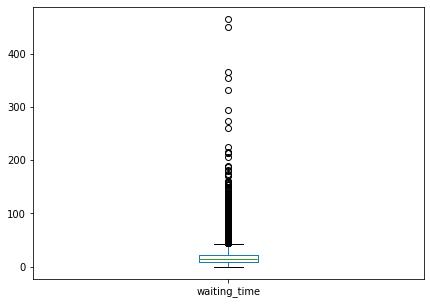

In [48]:
box_plot('waiting_time')

In [49]:
np.percentile(telecom_dataset['waiting_time'], [95, 99])

array([40., 60.])

По графикам видно, что есть много выбросов, в том числе и одиночные. Для последующего исследования оставим данные, которые не превышают 95 перцентиль:

In [50]:
list = ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']
for i in list:
    telecom_dataset = telecom_dataset.loc[telecom_dataset[i] <= np.quantile(telecom_dataset[i], 0.95)]

In [51]:
telecom_dataset[['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']].describe().T

,count,mean,std,min,25%,50%,75%,max
calls_count,39972.0,6.675023,9.434850,1.0,1.0,3.0,8.0,62.0
call_duration,39972.0,234.032523,398.325177,0.0,0.0,15.0,295.0,1967.0
total_call_duration,39972.0,349.789252,455.497266,0.0,34.0,141.0,496.0,1993.0
waiting_time,39972.0,14.827905,9.929905,0.0,7.0,13.0,21.0,41.0


Посмотрим на total_call_duration подробнее. Сгруппируем данные по операторам и датам - сколько total_call_duration у каждого оператора в день:

In [52]:
telecom_dataset_duration = telecom_dataset.groupby(['operator_id', 'sessions_date'])['total_call_duration'].sum().sort_values().reset_index()
telecom_dataset_duration.tail(50)

,operator_id,sessions_date,total_call_duration
18286,890406.0,2019-11-18,3544
18287,921818.0,2019-11-10,3554
18288,912722.0,2019-11-07,3557
18289,937812.0,2019-11-28,3570
18290,890406.0,2019-10-24,3580
18291,920720.0,2019-10-08,3582
18292,887276.0,2019-10-01,3590
18293,944220.0,2019-11-11,3590
18294,893804.0,2019-09-24,3590
18295,898906.0,2019-09-03,3597


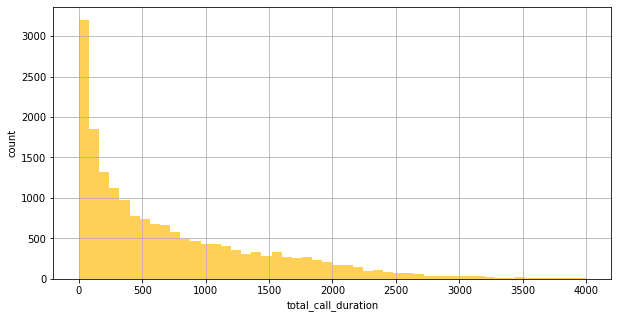

In [53]:
telecom_dataset_duration['total_call_duration'].plot(kind='hist',
                        bins=50, 
                        grid=True,
                        range=(0, 4000),
                        figsize=(10,5), 
                        color=['#FFCF56'],
                       );
plt.xlabel('total_call_duration')
plt.ylabel('count');

У большинства total_call_duration до 1000. Делаем вывод, что данные о времени звонка переданы в минутах.

**Выводы:**

На графиках виден большой разброс данных, много выбросов, посмотрели на 95, 99 перценцили, оставили те, которые не превышают 95 перцециль.

### Изучение категориальных данных

#### Внешние/внутренние звонки

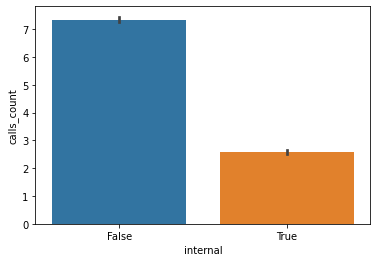

In [54]:
plt.figure() 
sns.barplot(x ='internal' , y ='calls_count' , data=telecom_dataset);

#### Входящие/исходящие звонки

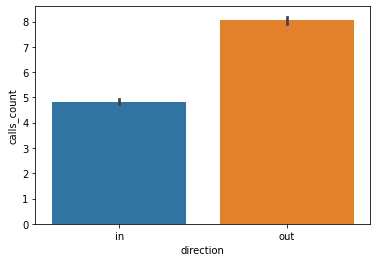

In [55]:
plt.figure() 
sns.barplot(x ='direction' , y ='calls_count' , data=telecom_dataset);

**Выводы:**

По графикам видим, что больше внешних вызовов, что логично, т.к. колл-центры взаимодействуют с клиентами извне, а также больше входящих звонков.

### Разделение колл-центров на категории

Разбиение будет происходить по соотношению исходящих и входящих звонков.

Учитываем, что в любом колл-центре вне зависмости от его направленности могут совершаться и те, и другие звонки.

Разделим звонки на категории:

In [56]:
def split_calls(row):
   
    """
     Эта функция для разбиения на категории звонков:
     внешний исходящий, внешний входящий, внутренний (в общем)
     
    """

    if row['internal'] == True:
        return 'внутренний'
    else:
        if row['direction'] == 'out':
            return 'внешний исходящий'
        else:
            return 'внешний входящий'
    
# создание нового столбца на основании полученных функцией значений
telecom_dataset['call_category'] = telecom_dataset.apply(split_calls, axis=1)

Составим сводную таблицу: для каждого колл-центра прописана сумма звонков для каждой из категорий:

In [57]:
telecom_dataset_pivot = telecom_dataset.pivot_table(index='user_id', 
                                                    columns='call_category', 
                                                    values='calls_count', 
                                                    aggfunc='sum')
telecom_dataset_pivot = telecom_dataset_pivot.fillna(0)
telecom_dataset_pivot.head(10)

call_category,внешний входящий,внешний исходящий,внутренний
user_id,,,
166377,194.0,2788.0,55.0
166391,14.0,0.0,9.0
166392,200.0,0.0,1.0
166399,20.0,0.0,0.0
166405,2665.0,4014.0,34.0
166406,220.0,2750.0,82.0
166407,106.0,198.0,562.0
166428,156.0,0.0,7.0
166481,58.0,0.0,0.0


Посчитаем доли числа звонков по категориям "внешний входящий" и "внешний исходящий", результаты запишем в новые столбцы:

In [58]:
telecom_dataset_pivot['sum'] = telecom_dataset_pivot['внешний входящий'] + telecom_dataset_pivot['внешний исходящий'] + telecom_dataset_pivot['внутренний']
telecom_dataset_pivot['% in'] =  round((telecom_dataset_pivot['внешний входящий'] * 100/ telecom_dataset_pivot['sum']), 2)
telecom_dataset_pivot['% out'] =  round((telecom_dataset_pivot['внешний исходящий'] * 100/ telecom_dataset_pivot['sum']), 2)
telecom_dataset_pivot.head(5)

call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out
user_id,,,,,,
166377,194.0,2788.0,55.0,3037.0,6.39,91.80
166391,14.0,0.0,9.0,23.0,60.87,0.00
166392,200.0,0.0,1.0,201.0,99.50,0.00
166399,20.0,0.0,0.0,20.0,100.00,0.00
166405,2665.0,4014.0,34.0,6713.0,39.70,59.79


Разделим колл-центры на типы, в зависимости от доли исх. и вх. звонков, которые они совершили за данный нам период:

In [59]:
def split_call_centre(row):
   
    """
     Эта функция для разбиения на категории колл-центры:
     те, которые специализируются на исх. звонках, внутренних и другие.
     
    """
    if row['% in'] >= 60:
        return 'вх. звонки'
    elif row['% out'] >= 60:
        return 'исх. звонки'
    else:
        return 'другое'
    
# создание нового столбца на основании полученных функцией значений
telecom_dataset_pivot['call_centre_category'] = telecom_dataset_pivot.apply(split_call_centre, axis=1)

In [60]:
telecom_dataset_pivot.sample(5)

call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
user_id,,,,,,,
166485,678.0,2579.0,536.0,3793.0,17.88,67.99,исх. звонки
168481,43.0,20.0,6.0,69.0,62.32,28.99,вх. звонки
167235,537.0,936.0,0.0,1473.0,36.46,63.54,исх. звонки
167955,128.0,764.0,0.0,892.0,14.35,85.65,исх. звонки
167930,35.0,5.0,0.0,40.0,87.50,12.50,вх. звонки


Посмотрим на топ-10 по самому большому количеству звонков:

In [61]:
telecom_dataset_pivot.sort_values(by='sum', ascending=False).head(10)

call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
user_id,,,,,,,
168187,4859.0,10908.0,546.0,16313.0,29.79,66.87,исх. звонки
168361,42.0,12144.0,73.0,12259.0,0.34,99.06,исх. звонки
168062,437.0,11171.0,626.0,12234.0,3.57,91.31,исх. звонки
167626,34.0,11714.0,38.0,11786.0,0.29,99.39,исх. звонки
166658,1710.0,5477.0,21.0,7208.0,23.72,75.99,исх. звонки
166405,2665.0,4014.0,34.0,6713.0,39.70,59.79,другое
168252,1572.0,4393.0,298.0,6263.0,25.10,70.14,исх. звонки
166782,1574.0,3859.0,85.0,5518.0,28.52,69.93,исх. звонки
167150,761.0,3127.0,1293.0,5181.0,14.69,60.36,исх. звонки


Посмотрим на топ-10 по наименьшему числу звонков:

In [62]:
telecom_dataset_pivot.sort_values(by='sum').head(10)

call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
user_id,,,,,,,
168578,1.0,0.0,0.0,1.0,100.0,0.0,вх. звонки
167981,1.0,0.0,0.0,1.0,100.0,0.0,вх. звонки
168490,2.0,0.0,0.0,2.0,100.0,0.0,вх. звонки
166554,0.0,0.0,2.0,2.0,0.0,0.0,другое
168013,2.0,0.0,0.0,2.0,100.0,0.0,вх. звонки
168340,2.0,0.0,0.0,2.0,100.0,0.0,вх. звонки
167682,2.0,0.0,0.0,2.0,100.0,0.0,вх. звонки
166584,2.0,0.0,0.0,2.0,100.0,0.0,вх. звонки
167139,1.0,0.0,1.0,2.0,50.0,0.0,другое


In [63]:
telecom_dataset_merge = telecom_dataset.merge(telecom_dataset_pivot, on='user_id')
telecom_dataset_merge.sample()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
17089,167071,out,False,913942.0,False,11,893,1056,2019-10-01,15,внешний исходящий,1676.0,772.0,13.0,2461.0,68.1,31.37,вх. звонки


Разделим датасет на два - по категориям колл-центров:

In [64]:
out_call_centre = telecom_dataset_merge[telecom_dataset_merge['call_centre_category'] == 'исх. звонки']
in_call_centre = telecom_dataset_merge[telecom_dataset_merge['call_centre_category'] == 'вх. звонки']
other_call_centre = telecom_dataset_merge[telecom_dataset_merge['call_centre_category'] == 'другое']

In [65]:
call_center_types = telecom_dataset_merge.groupby('call_centre_category')['user_id'].nunique().reset_index()
call_center_types

,call_centre_category,user_id
0,вх. звонки,155
1,другое,50
2,исх. звонки,102


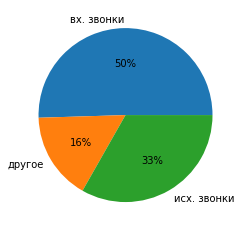

In [66]:
labels = call_center_types['call_centre_category']
plt.pie(call_center_types['user_id'], labels=labels, autopct='%.0f%%')
plt.show()

**Выводы:**

- разделили звонки на категории для последующего разбиения колл-центров на категории: 
                   -- 50% - на вх. звонках, 33% - на исх. звонках, 16% - универсальные
- составили датасеты с данными о звонках колл-центров, специализирующихся на исходящих звонках и входящих
- получили топ-10 по наибольшему и наименьшему числу звонков: в 10-ке лучших по этому признаку в основном колл-центры категории "исх. звонки", в топ-10 худших - колл-центры ктегории "вх. звонки", что логично, поскольку звонки с предложениями услуг обычно не занимают много времени по длительности


## Определение порогов эффективности операторов

Исходя из того, что нам дано, судить по эффективности операторов можно по следующим показателям: 
- пропущенные звонки
- количество звонков
- время ожидания

### Для колл-центров, специализирующихся на исходящих звонках

#### По количеству звонков

Соберем таблицу, где для каждого оператора есть число звонков, их продолжительность за весь период.

Посчитаем, сколько в среднем составляет продолжительность одного звонка для каждого оператора.

Далее считаем, сколько оператор способен с этими данными совершить звонков за смену.

In [67]:
out_call_per_day = out_call_centre.groupby(['operator_id'])['calls_count', 'total_call_duration'].sum().reset_index()
out_call_per_day['total_duration_for_one_call'] = round((out_call_per_day['total_call_duration']/out_call_per_day['calls_count']), 0)
out_call_per_day['calls_per_day'] = round((480/(out_call_per_day['total_duration_for_one_call'])), 0)
out_call_per_day.head()

/tmp/ipykernel_64/1041324963.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  out_call_per_day = out_call_centre.groupby(['operator_id'])['calls_count', 'total_call_duration'].sum().reset_index()


,operator_id,calls_count,total_call_duration,total_duration_for_one_call,calls_per_day
0,879896.0,469,26617,57.0,8.0
1,879898.0,2490,65865,26.0,18.0
2,880020.0,45,2525,56.0,9.0
3,880022.0,171,15318,90.0,5.0
4,880026.0,1129,58112,51.0,9.0


Считаем среднее число звонков в смену(считаем 8 часов) - пороговое значение:

In [68]:
limit_call_number = round(out_call_per_day['calls_per_day'].median(), 0)
limit_call_number

10.0

In [69]:
def split_number_calls(row):

    """
     С помощью этой функции определяется эффективен или неэффективен оператор по числу звонков
     
    """
    
    if (row['calls_per_day'] >= limit_call_number):
        return True
    else:
        return False
    
# создание нового столбца на основании полученных функцией значений
out_call_per_day['is_operator_effective_by_calls'] = out_call_per_day.apply(split_number_calls, axis=1)
out_call_per_day.sample()

,operator_id,calls_count,total_call_duration,total_duration_for_one_call,calls_per_day,is_operator_effective_by_calls
222,919418.0,2,10,5.0,96.0,True


Оставляем только нужные столбцы:

In [70]:
out_call_per_day = out_call_per_day[['operator_id', 'is_operator_effective_by_calls']]
out_call_per_day.head()

,operator_id,is_operator_effective_by_calls
0,879896.0,False
1,879898.0,True
2,880020.0,False
3,880022.0,False
4,880026.0,False


Объединяем таблицы out_call_centre и out_call_per_day:

In [71]:
out_call_centre = out_call_centre.merge(out_call_per_day, on='operator_id')
out_call_centre.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category,is_operator_effective_by_calls
0,166377,out,True,880022.0,True,3,0,5,2019-08-05,2,внутренний,194.0,2788.0,55.0,3037.0,6.39,91.8,исх. звонки,False
1,166377,out,False,880022.0,True,3,0,25,2019-08-05,8,внешний исходящий,194.0,2788.0,55.0,3037.0,6.39,91.8,исх. звонки,False
2,166377,out,False,880022.0,False,2,558,568,2019-08-08,5,внешний исходящий,194.0,2788.0,55.0,3037.0,6.39,91.8,исх. звонки,False
3,166377,out,False,880022.0,True,4,0,28,2019-08-08,7,внешний исходящий,194.0,2788.0,55.0,3037.0,6.39,91.8,исх. звонки,False
4,166377,out,False,880022.0,True,2,0,10,2019-08-09,5,внешний исходящий,194.0,2788.0,55.0,3037.0,6.39,91.8,исх. звонки,False


Посмотрим, сколько эффективных и неэффективных операторов в каждом колл-центре:

In [72]:
is_operator_effective_by_calls = out_call_centre.pivot_table(index='user_id', 
                                                    columns='is_operator_effective_by_calls', 
                                                    values='operator_id', 
                                                    aggfunc='count')
is_operator_effective_by_calls = is_operator_effective_by_calls.fillna(0)
is_operator_effective_by_calls.head()

is_operator_effective_by_calls,False,True
user_id,,
166377,373.0,8.0
166406,109.0,157.0
166485,338.0,164.0
166495,0.0,133.0
166503,242.0,2.0


Посчитаем долю неэффективных операторов:

In [73]:
is_operator_effective_by_calls['count'] = is_operator_effective_by_calls[False] + is_operator_effective_by_calls[True]
is_operator_effective_by_calls['% false'] = is_operator_effective_by_calls[False]*100/is_operator_effective_by_calls['count']
is_operator_effective_by_calls.head()

is_operator_effective_by_calls,False,True,count,% false
user_id,,,,
166377,373.0,8.0,381.0,97.900262
166406,109.0,157.0,266.0,40.977444
166485,338.0,164.0,502.0,67.330677
166495,0.0,133.0,133.0,0.000000
166503,242.0,2.0,244.0,99.180328


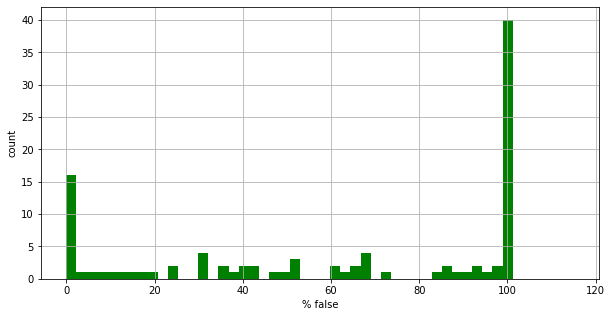

In [74]:
is_operator_effective_by_calls['% false'].plot(kind='hist',
                        bins=50, 
                        grid=True,
                        range=(0, 115),
                        figsize=(10,5), 
                        color=['#008000'],
                       );
plt.xlabel('% false')
plt.ylabel('count');

Топ-10 колл-центров по наибольшему числу неэффективных операторов:

In [75]:
is_operator_effective_by_calls.sort_values(by='% false', ascending=False).head(10)

is_operator_effective_by_calls,False,True,count,% false
user_id,,,,
168603,6.0,0.0,6.0,100.0
166711,17.0,0.0,17.0,100.0
166812,79.0,0.0,79.0,100.0
166833,200.0,0.0,200.0,100.0
167479,187.0,0.0,187.0,100.0
167475,44.0,0.0,44.0,100.0
166884,89.0,0.0,89.0,100.0
167471,157.0,0.0,157.0,100.0
166936,40.0,0.0,40.0,100.0


Топ-10 коллцентров с наименьшим числов неэффективных операторов:

In [76]:
is_operator_effective_by_calls.sort_values(by='% false').head(10)

is_operator_effective_by_calls,False,True,count,% false
user_id,,,,
167645,0.0,25.0,25.0,0.0
167130,0.0,20.0,20.0,0.0
167829,0.0,27.0,27.0,0.0
167816,0.0,80.0,80.0,0.0
167727,0.0,58.0,58.0,0.0
168025,0.0,28.0,28.0,0.0
168064,0.0,103.0,103.0,0.0
168093,0.0,4.0,4.0,0.0
167634,0.0,34.0,34.0,0.0


#### По времени ожидания ответа

In [77]:
not_missed = out_call_centre[out_call_centre['is_missed_call'] == False]

In [78]:
not_missed_waiting_time_median = not_missed['waiting_time'].median()
not_missed_waiting_time_median

12.0

In [79]:
not_missed_waiting_time_mode = statistics.mode(not_missed['waiting_time'])
not_missed_waiting_time_mode

10

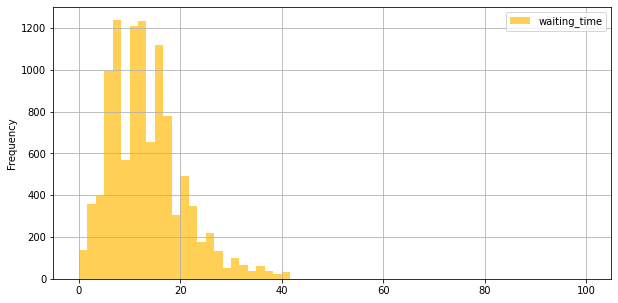

In [80]:
not_missed[['waiting_time']].plot(kind='hist',
                        bins=60, 
                        grid=True,
                        range=(0, 100),
                        figsize=(10,5), 
                        color=['#FFCF56'],
                       );

In [81]:
not_missed['waiting_time'].describe()

count    10756.000000
mean        13.136947
std          7.173478
min          0.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         41.000000
Name: waiting_time, dtype: float64

Когда именно клиент ответит на звонок или сбросит ли он - от оператора не зависит. Поэтому оценить эффективность оператора с помощью этого параментра можем только по следующим критериям:

- слишком мало ждал ответ
- слишком долго звонил


Примем за пороговые значения 12 и 30.

Далее оцениваем по этому признаку по пропущенным звонкам.

In [82]:
missed = out_call_centre[out_call_centre['is_missed_call'] == True]

In [83]:
def split_waiting_time(row):

    """
     С помощью этой функции определяется эффективен или неэффективен оператор
     по времени ожидания звонка
     
    """
    if row['is_missed_call'] == True:
        if 12 <= row['waiting_time'] <= 30:
            return True
        else:
            return False
    else:
        return True
    
# создание нового столбца на основании полученных функцией значений
out_call_centre['is_operator_effective_by_wait_time'] = out_call_centre.apply(split_waiting_time, axis=1)
out_call_centre.sample()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category,is_operator_effective_by_calls,is_operator_effective_by_wait_time
14773,168062,out,False,947644.0,False,10,718,833,2019-11-28,12,внешний исходящий,437.0,11171.0,626.0,12234.0,3.57,91.31,исх. звонки,False,True


Посмотрим, сколько эффективных и неэффективных операторов в каждом колл-центре:

In [84]:
is_operator_effective_by_wait_time = out_call_centre.pivot_table(index='user_id', 
                                                    columns='is_operator_effective_by_wait_time', 
                                                    values='operator_id', 
                                                    aggfunc='count')
is_operator_effective_by_wait_time = is_operator_effective_by_wait_time.fillna(0)
is_operator_effective_by_wait_time.head()

is_operator_effective_by_wait_time,False,True
user_id,,
166377,90.0,291.0
166406,44.0,222.0
166485,93.0,409.0
166495,28.0,105.0
166503,37.0,207.0


Посчитаем долю неэффективных операторов:

In [85]:
is_operator_effective_by_wait_time['count'] = is_operator_effective_by_wait_time[False] + is_operator_effective_by_wait_time[True]
is_operator_effective_by_wait_time['% false'] = is_operator_effective_by_wait_time[False]*100/is_operator_effective_by_wait_time['count']
is_operator_effective_by_wait_time.head()

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
166377,90.0,291.0,381.0,23.622047
166406,44.0,222.0,266.0,16.541353
166485,93.0,409.0,502.0,18.525896
166495,28.0,105.0,133.0,21.052632
166503,37.0,207.0,244.0,15.163934


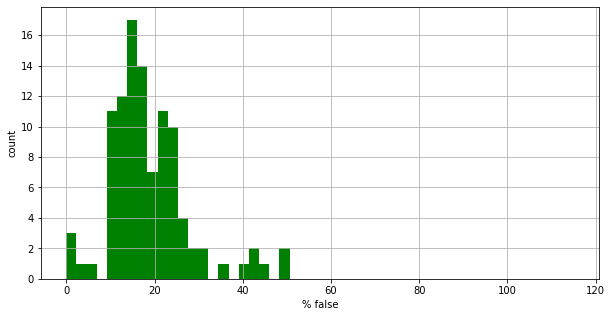

In [86]:
is_operator_effective_by_wait_time['% false'].plot(kind='hist',
                        bins=50, 
                        grid=True,
                        range=(0, 115),
                        figsize=(10,5), 
                        color=['#008000'],
                       );
plt.xlabel('% false')
plt.ylabel('count');

Топ-10 колл-центров по наибольшему числу неэффективных операторов:

In [87]:
is_operator_effective_by_wait_time.sort_values(by='% false', ascending=False).head(10)

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
168253,30.0,30.0,60.0,50.000000
166507,1.0,1.0,2.0,50.000000
166511,249.0,296.0,545.0,45.688073
168412,60.0,78.0,138.0,43.478261
167125,110.0,150.0,260.0,42.307692
166609,11.0,17.0,28.0,39.285714
167923,7.0,13.0,20.0,35.000000
168047,11.0,24.0,35.0,31.428571
168228,32.0,72.0,104.0,30.769231


Топ-10 коллцентров с наименьшим числов неэффективных операторов:

In [88]:
is_operator_effective_by_wait_time.sort_values(by='% false').head(10)

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
167530,0.0,4.0,4.0,0.000000
168093,0.0,4.0,4.0,0.000000
167634,0.0,34.0,34.0,0.000000
168000,1.0,22.0,23.0,4.347826
167175,15.0,208.0,223.0,6.726457
167124,3.0,28.0,31.0,9.677419
167338,9.0,78.0,87.0,10.344828
166708,21.0,181.0,202.0,10.396040
166691,26.0,223.0,249.0,10.441767


### Для колл-центров, специализирующихся на входящих звонках

#### По пропущенным звонкам

In [89]:
in_call_centre['user_id'].nunique()

155

Сделаем срез данных по внешним входящим пропущенным звонкам:

In [90]:
in_missed_call = in_call_centre[
    (in_call_centre['direction'] == 'in') 
    & (in_call_centre['is_missed_call'] == True) 
    & (in_call_centre['internal'] == False)
]
in_missed_call.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
420,166391,in,False,NaN,True,2,0,71,2019-08-07,36,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
421,166391,in,False,NaN,True,1,0,20,2019-08-08,20,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
422,166391,in,False,NaN,True,1,0,33,2019-08-09,33,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
426,166391,in,False,NaN,True,1,0,9,2019-09-18,9,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
427,166391,in,False,NaN,True,1,0,1,2019-09-20,1,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки


Сгруппируем звонки по колл-центрам:

In [91]:
in_missed_call_by_users = in_missed_call.pivot_table(index='user_id', 
                                                    values='calls_count', 
                                                    aggfunc='sum').reset_index()
in_missed_call_by_users.head()

,user_id,calls_count
0,166391,11
1,166392,104
2,166399,10
3,166428,38
4,166481,57


Сделаем срез данных по внешним исходящим звонкам:

In [92]:
all_call = in_call_centre[
    (in_call_centre['direction'] == 'in')  
    & (in_call_centre['internal'] == False)
]
all_call.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
416,166391,in,False,882476.0,False,1,175,186,2019-08-06,11,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
418,166391,in,False,882478.0,False,1,57,70,2019-08-07,13,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
420,166391,in,False,NaN,True,2,0,71,2019-08-07,36,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
421,166391,in,False,NaN,True,1,0,20,2019-08-08,20,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки
422,166391,in,False,NaN,True,1,0,33,2019-08-09,33,внешний входящий,14.0,0.0,9.0,23.0,60.87,0.0,вх. звонки


Сгруппируем эти звонки по колл-центрам:

In [93]:
all_call = all_call.pivot_table(index='user_id', 
                                values='calls_count', 
                                aggfunc='sum').reset_index()
all_call.head()

,user_id,calls_count
0,166391,14
1,166392,200
2,166399,20
3,166428,156
4,166481,58


Объединим две сгруппированные таблицы:

In [94]:
call_by_users = in_missed_call_by_users.merge(all_call, on='user_id', suffixes=['_missed','_all'])
call_by_users.head()

,user_id,calls_count_missed,calls_count_all
0,166391,11,14
1,166392,104,200
2,166399,10,20
3,166428,38,156
4,166481,57,58


Посчитаем долю пропущенных звонков, запишем результат в новый столбец:

In [95]:
call_by_users['%_missed'] = round((call_by_users['calls_count_missed']*100/call_by_users['calls_count_all']), 2)
call_by_users.head()

,user_id,calls_count_missed,calls_count_all,%_missed
0,166391,11,14,78.57
1,166392,104,200,52.00
2,166399,10,20,50.00
3,166428,38,156,24.36
4,166481,57,58,98.28


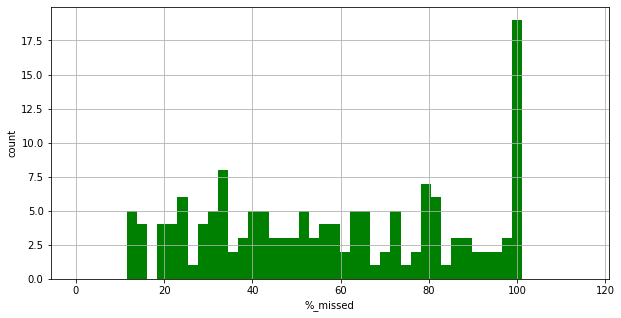

In [96]:
call_by_users['%_missed'].plot(kind='hist',
                        bins=50, 
                        grid=True,
                        range=(0, 115),
                        figsize=(10,5), 
                        color=['#008000'],
                       );
plt.xlabel('%_missed')
plt.ylabel('count');

Топ-10 колл-центров по наибольшему числу пропусков:

In [97]:
call_by_users.sort_values(by='%_missed', ascending=False).head(10)

,user_id,calls_count_missed,calls_count_all,%_missed
102,167939,3,3,100.0
137,168329,9,9,100.0
43,167077,48,48,100.0
62,167265,8,8,100.0
66,167364,10,10,100.0
81,167631,58,58,100.0
85,167721,7,7,100.0
88,167768,11,11,100.0
49,167114,5,5,100.0
107,167981,1,1,100.0


Топ-10 колл-центров по наименьшему числу пропусков:

In [98]:
call_by_users.sort_values(by='%_missed').head(10)

,user_id,calls_count_missed,calls_count_all,%_missed
40,167059,75,641,11.70
63,167272,17,138,12.32
17,166697,1,8,12.50
32,166955,6,47,12.77
35,166985,7,54,12.96
29,166908,8,57,14.04
11,166604,67,453,14.79
95,167870,27,182,14.84
136,168315,7,46,15.22
106,167976,17,91,18.68


#### По времени ожидания ответа

In [99]:
in_call_centre.sample()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category
5030,166582,out,False,885876.0,False,3,38,38,2019-10-12,0,внешний исходящий,3872.0,643.0,3.0,4518.0,85.7,14.23,вх. звонки


In [100]:
missed = in_call_centre[in_call_centre['is_missed_call'] == True]

In [101]:
missed_waiting_time_median = missed['waiting_time'].median()
missed_waiting_time_median

11.0

In [102]:
missed_waiting_time_mode = statistics.mode(missed['waiting_time'])
missed_waiting_time_mode

2

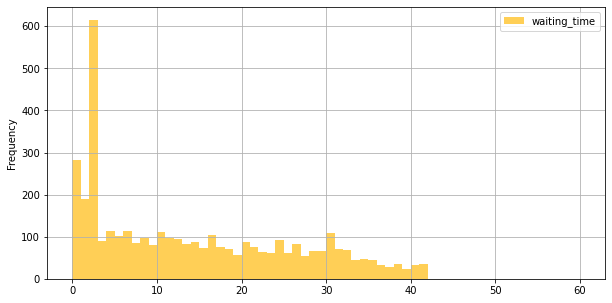

In [103]:
missed[['waiting_time']].plot(kind='hist',
                        bins=60, 
                        grid=True,
                        range=(0, 60),
                        figsize=(10,5), 
                        color=['#FFCF56'],
                       );

In [104]:
missed['waiting_time'].describe()

count    3901.000000
mean       13.874135
std        11.860224
min         0.000000
25%         2.000000
50%        11.000000
75%        24.000000
max        41.000000
Name: waiting_time, dtype: float64

Оценить эффективность оператора с помощью этого параментра можем на основе данных о числе пропусков при разном времени ожидания.

Примем за пороговое значение - 5.

In [105]:
def split_waiting_time(row):

    """
     С помощью этой функции определяется эффективен или неэффективен оператор
     по времени ожидания звонка
     
    """

    if row['waiting_time'] <= 5:
        return True
    else:
        return False

    
# создание нового столбца на основании полученных функцией значений
in_call_centre['is_operator_effective_by_wait_time'] = in_call_centre.apply(split_waiting_time, axis=1)
in_call_centre.sample()

/tmp/ipykernel_64/2706081263.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_call_centre['is_operator_effective_by_wait_time'] = in_call_centre.apply(split_waiting_time, axis=1)


,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category,внешний входящий,внешний исходящий,внутренний,sum,% in,% out,call_centre_category,is_operator_effective_by_wait_time
13373,166958,out,False,898422.0,True,2,0,14,2019-09-13,7,внешний исходящий,297.0,23.0,0.0,320.0,92.81,7.19,вх. звонки,False


Посмотрим, сколько эффективных и неэффективных операторов в каждом колл-центре:

In [106]:
is_operator_effective_by_wait_time = in_call_centre.pivot_table(index='user_id', 
                                                    columns='is_operator_effective_by_wait_time', 
                                                    values='operator_id', 
                                                    aggfunc='count')
is_operator_effective_by_wait_time = is_operator_effective_by_wait_time.fillna(0)
is_operator_effective_by_wait_time.head()

is_operator_effective_by_wait_time,False,True
user_id,,
166391,5.0,0.0
166392,41.0,0.0
166399,5.0,3.0
166428,55.0,1.0
166481,1.0,0.0


Посчитаем долю неэффективных операторов:

In [107]:
is_operator_effective_by_wait_time['count'] = is_operator_effective_by_wait_time[False] + is_operator_effective_by_wait_time[True]
is_operator_effective_by_wait_time['% false'] = is_operator_effective_by_wait_time[False]*100/is_operator_effective_by_wait_time['count']
is_operator_effective_by_wait_time.head()

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
166391,5.0,0.0,5.0,100.000000
166392,41.0,0.0,41.0,100.000000
166399,5.0,3.0,8.0,62.500000
166428,55.0,1.0,56.0,98.214286
166481,1.0,0.0,1.0,100.000000


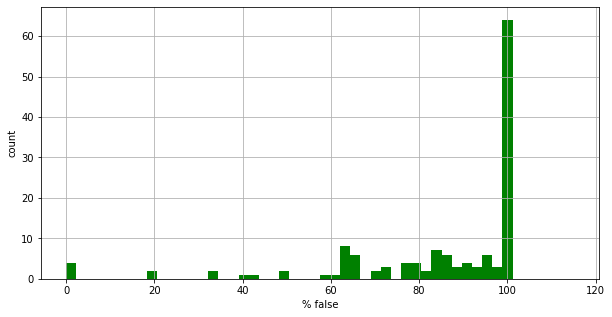

In [108]:
is_operator_effective_by_wait_time['% false'].plot(kind='hist',
                        bins=50, 
                        grid=True,
                        range=(0, 115),
                        figsize=(10,5), 
                        color=['#008000'],
                       );
plt.xlabel('% false')
plt.ylabel('count');

Топ-10 колл-центров по наибольшему числу неэффективных операторов:

In [109]:
is_operator_effective_by_wait_time.sort_values(by='% false', ascending=False).head(10)

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
166391,5.0,0.0,5.0,100.0
168016,7.0,0.0,7.0,100.0
167162,16.0,0.0,16.0,100.0
167158,60.0,0.0,60.0,100.0
167998,3.0,0.0,3.0,100.0
167122,3.0,0.0,3.0,100.0
168004,4.0,0.0,4.0,100.0
167102,59.0,0.0,59.0,100.0
167079,17.0,0.0,17.0,100.0


Топ-10 коллцентров с наименьшим числов неэффективных операторов:

In [110]:
is_operator_effective_by_wait_time.sort_values(by='% false').head(10)

is_operator_effective_by_wait_time,False,True,count,% false
user_id,,,,
168459,0.0,1.0,1.0,0.000000
167364,0.0,1.0,1.0,0.000000
168315,0.0,10.0,10.0,0.000000
168190,0.0,6.0,6.0,0.000000
167575,4.0,17.0,21.0,19.047619
167238,1.0,4.0,5.0,20.000000
167397,2.0,4.0,6.0,33.333333
167840,1.0,2.0,3.0,33.333333
168010,2.0,3.0,5.0,40.000000


**Выводы:**

Эффективность операторов - колл-центров оценили по трём признакам:

- числу пропусков
- времени ожидания
- количеству звонков

1. По колл-центрам, специализирующихся на исх. звонках, получили достаточно ысокую неэффективность по числу пропусков, но в целом это картина реалистична, поскольку потенциальные клиенты часто пропускают подобные звонки, по времени ожидания и количеству звонков в общем равномерно по неэффективности, без скачков
2. По колл-центрам, которые совершают в основном вх. звонки, заметили, что здесь среди них много тех, у кого ещё очень мало звонков и даже они могут быть внутренними, это может объяснять одинаковое число колл-центров с высокой неэффективностью по всем трём признакам

## Проверка гипотез

- Число пропущенных исходящих звонков в будни и в выходные в колл-центре, специализация которого исх. звонки, различается

Введем нулевую и альтернативные гипотезы:

H0 : Количество пропущенных исходящих звонков в будни и в выходные равно 

H1 : Количество пропущенных исходящих звонков в будни и в выходные различается

Уровень значимости: alpha = 0.05

Рассчитаем p-value:

При p-value меньше выбранного уровня значимости будут основания отвергнуть нулевую гипотезу в пользу альтернативной. Иначе - сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [111]:
telecom_dataset.sample()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,sessions_date,waiting_time,call_category
50632,168252,in,False,940588.0,True,1,142,144,2019-11-19,2,внешний входящий


In [112]:
telecom_dataset_merge['day'] = telecom_dataset['sessions_date'].dt.day_name()
telecom_dataset_merge['day'].unique()

array(['Sunday', 'Monday', nan, 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday'], dtype=object)

In [113]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Sunday', 'Saturday']

In [114]:
query_1 = telecom_dataset_merge.query('(day in @weekdays) and (internal == False) and (direction == "out") and (is_missed_call == True) and (call_centre_category == "исх. звонки")')['calls_count']
query_2 = telecom_dataset_merge.query('(day in @weekends) and (direction == "out") and (internal == False) and (is_missed_call == True) and (call_centre_category == "исх. звонки")')['calls_count']

In [115]:
alpha = .05
results = stats.ttest_ind(query_1, query_2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')

p-значение: 0.8980324064945179
Недостаточно оснований, чтобы отвергнуть нулевую гипотезу


**Выводы:**

Это показывает, что не нужно различать по дням звонки у исх. колл-центров, разницы в работе нет

- Время ожидания ответа у исходящих звонков и входящих различается

Введем нулевую и альтернативные гипотезы:

H0 : Время ожидания ответа у исходящих звонков и входящих не отличается

H1 : Время ожидания ответа у исходящих звонков и входящих различается

Уровень значимости: alpha = 0.05

In [116]:
query_1 = telecom_dataset.query('(direction == "in") and (is_missed_call == False)')['waiting_time']
query_2 = telecom_dataset.query('(direction == "out") and (is_missed_call == False)')['waiting_time']

In [117]:
alpha = .05
results = stats.ttest_ind(query_1, query_2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')

p-значение: 2.4475847567457984e-126
Имеются основания отвергнуть нулевую гипотезу


In [118]:
query_1 = telecom_dataset.query('(direction == "in") and (is_missed_call == False)')['waiting_time']
query_2 = telecom_dataset.query('(direction == "out") and (is_missed_call == False)')['waiting_time']

In [119]:
alpha = .05
results = stats.ttest_ind(query_1, query_2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')

p-значение: 2.4475847567457984e-126
Имеются основания отвергнуть нулевую гипотезу


То есть вероятность, что время ожидания ответа у входящих и исходщих вызовов отличается

## Выводы

**Общий вывод**

1. Данные подготовили к анализу:
    - удалили дубликаты, привели типы данных, добавили столбец с датами и временем ожидания ответа 
    
2. Исследовательский анализ:
    - построили гистограммы и диаграммы размаха для количественных данных, учли выбросы, оставили данные, не превышающие 95 перценциль
    - изучили категориальные данные
       
3. Разделение колл-центров на категории
    - разбили звонки на категории
    - на основе звонков провели разделение колл-центров на категории (исх. и вх.)
    - составили два соответствующих датесета
    
4. Определение порогов эффективности операторов, колл-центров
    - провели проверку операторов/колл-центров по признакам: кол-во пропущенных звонков, числа звонков, времени ожидания
    - на основе звонков провели разделение колл-центров на категории (исх. и вх.)
    - посчитали долю неэффективных операторов, построили гистограммы
    
5. Проверка гипотез
    - Число пропущенных исходящих звонков в будни и в выходные различается
    - Время ожидания ответа у исходящих звонков и входящих различается

**Заключение:**

Колл-центров категории "исх. звонки"

- по числу звонков самый минимальный процент неэффективных операторов - 0%, максимальный - 100%, большее количество колл-центров имеют именно такие
- по времени ожидания минимальный процент неэффективных операторов - 0%, максимальный - 50%, в большинстве колл-центров процент неэффективных операторов в диапазоне от 10 до 30%

Колл-центров категории "вх. звонки"

- по пропускам самый минимальный процент неэффективных операторов - 11%, максимальный - 100%, в среднем процент неэффективных операторов в диапазоне от 11% до 100% равномерно по кол-ву колл-центров
- по времени ожидания самый минимальный процент неэффективных операторов - 0%, максимальный - 100%, у большинства колл-центров доля неэффективных операторов составляет 65 - 100 %

Определение неэффективных операторов многим должна быть интересна, считаю, что в целом это положительно будет влиять на анализ работы колл-центра с возможными корректировками методики работы.